# New York City Taxi Trip Duration

In this notebook, I use 3 dataset from Kaggle. They are as the followings.  
[New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration)   
[New York City Taxi with OSRM](https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm)  
[Weather data in New York City - 2016](https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016)  

  
I am trying to  build a model that predicts the total ride duration of taxi trips in New York City, and visualize the data.   
The primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.  
  
The loss function used un this notebook is RMSLE (Root  Mean Squared Logarithmic Error)  
![1](RMSLE.JPG)

The following are some useful packages that are often used by developers.  
![2](package_visualization_1.JPG)
![3](package_visualization_2.JPG)
![5](package_visualization_3.JPG)

## New York City Taxi Trip Duration Dataset

-**id** : a unique identifier for each trip  
-**vendor_id** : a code indicating the provider associated with the trip record    
-**pickup_datetime** : date and time when the meter was engaged  
-**dropoff_datetime** : date and time when the meter was disengaged  
-**passenger_count** : the number of passengers in the vehicle (driver entered value)  
-**pickup_longitude** : the longitude where the meter was engaged  
-**pickup_latitude** : the latitude where the meter was engaged  
-**dropoff_longitude** : the longitude where the meter was disengaged  
-**dropoff_latitude** : the latitude where the meter was disengaged  
-**store_and_fwd_flag** : This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip  
-**trip_duration** : duration of the trip in seconds  

## New York City Taxi with OSRM Dataset

***Content***  

**starting_street**  
The street where the taxi-trip starts. In version 1 this field contained a lot of empty values. That has been dealt with.
  
**end_street**

The street where the taxi-trip ends. In version 1 this field contained a lot of empty values. That has been dealt with.

**total_distance**

The total distance is measured between the pickup coordinates and the drop-off coordinates in train.csv and test.csv. The unit is meters.

**total_travel_time**

The total travel time for that data point in seconds

**number_of_steps**

The number of steps on that trip. One step consists of some driving and an action the taxi needs to perform. It can be something like a turn or going on to a highway. See step_maneuvers for more information.

**street_for_each_step**

A list of streets where each step occurs. Multiple steps can be performed on the same street. Therefore there might the same street might occur multiple times.

(The values are stored as a string separated by '|')

**distance_per_step**

The distance for each step.

(The values are stored as a string separated by '|')

**travel_time_per_step**

The travel time for each step

(The values are stored as a string separated by '|')

**step_maneuvers**

The action (or maneuver) performed in each step. The possible maneuvers are:

-**turn**: a basic turn
-**new name**: no turn is taken/possible, but the road name changes.
-**depart**: The trip starts
-**arrive**: The trip ends
-**merge**: Merge onto a street (e.g. getting on the highway from a ramp)
-**on ramp**: Entering a highway (direction given my modifier )
-**off ramp**: Exiting a highway
-**fork**: The road forks
-**end of road**: The road ends in a T intersection
-**continue**: Turn to stay on the same road
-**roundabout**: A roundabout
-**rotary**: A traffic circle (a bigger roundabout)
-**roundabout turn**: A small roundabout that can be treated as a regular turn
(The values are stored as a string separated by '|')

**step_direction**

The direction for each action (or maneuver)

**step_location_list**

The coordinates for each action (or maneuver)

## Weather data in New York City - 2016 Dataset

**Content**  
Weather data collected from the National Weather Service. It contains the first six months of 2016, for a weather station in central park. It contains for each day the minimum temperature, maximum temperature, average temperature, precipitation, new snow fall, and current snow depth. The temperature is measured in Fahrenheit and the depth is measured in inches. T means that there is a trace of precipitation.  
  
**Acknowledgements**  
The data was retrieved on 20th of July, 2017 on  [National Weather Service Forecast Office](http://w2.weather.gov/climate/xmacis.php?wfo=okx)

## Import the packages 

In [5]:
import pandas as pd  #pandas for using dataframe and reading csv 
import numpy as np   #numpy for vector operations and basic maths 
#import simplejson    #getting JSON in simplified format
import urllib        #for url stuff
#import gmaps       #for using google maps to visulalize places on maps
import re            #for processing regular expressions
import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine # for calculating haversine distance
import math          #for basic maths operations
import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os  # for os commands
from scipy.misc import imread, imresize, imsave  # for plots 
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
import io
import base64
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
output_notebook()
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook

Loading BokehJS ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Read and check the head of training data and data from OSRM fastest route dataset 

In [41]:
s = time.time()
train_fr_1 = pd.read_csv('input/new_york_city_taxi_with_osrm/fastest_routes_train_part_1.csv')
train_fr_2 = pd.read_csv('input/new_york_city_taxi_with_osrm/fastest_routes_train_part_2.csv')
train_fr = pd.concat([train_fr_1, train_fr_2])
train_fr_new = train_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
train_df = pd.read_csv('input/new_york_city_taxi_with_osrm/train.csv')
train = pd.merge(train_df, train_fr_new, on = 'id', how = 'left')
train_df = train.copy()
end = time.time()
print("Time taken by above cell is {}.".format((end-s)))
train_df.head()

Time taken by above cell is 31.115694046020508.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1614.9,140.1,5.0


In [3]:
# checking if Ids are unique, 
start = time.time()
train_data = train_df.copy()
start = time.time()
print("Number of columns and rows and columns are {} and {} respectively.".format(train_data.shape[1], train_data.shape[0]))
if train_data.id.nunique() == train_data.shape[0]:
    print("Train ids are unique")
print("Number of Nulls - {}.".format(train_data.isnull().sum().sum()))
end = time.time()
print("Time taken by above cell is {}.".format(end-start))

Number of columns and rows and columns are 14 and 1458644 respectively.
Train ids are unique
Number of Nulls - 3.
Time taken by above cell is 0.8439419269561768.


**We see that training data contains 14 columns and ~1.4 Million data records with No nulls are present in out dataset.**

### Visualize the trip duration given using log-scale distplot in sns

We want to predict trip_duration of the test set, so we first check what kind of trips durations are present in the dataset. First, I plotted it on a plain scale and not on a log scale, and some of the records have very long trip durations ~100 hours. Such long trips are making all another trip invisible in the histogram on plain scale => We go ahead with the log scale. Another reason of using the log scale for visualizing trip-duration on the log scale is that this competition uses RMSLE matrix so it would make sense to visualize the target variable in log scale only.

Time taken by above cell is 1.473118543624878.


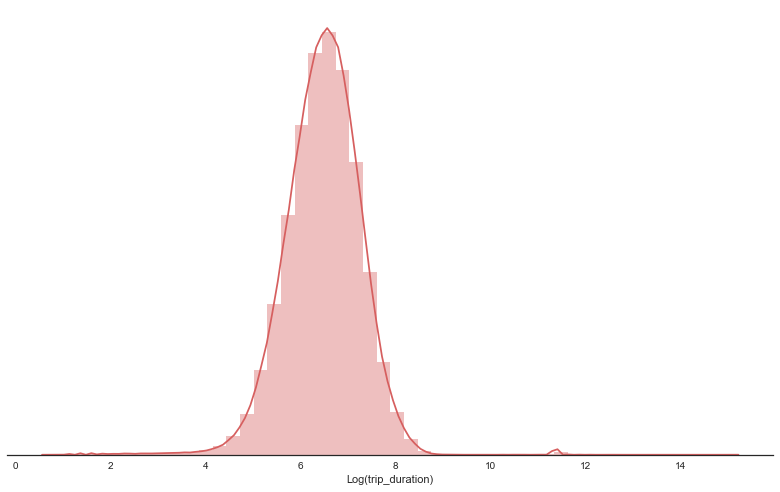

In [4]:
%matplotlib inline
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train_df['trip_duration'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

**Note**  
 It is clear with the above histogram and kernel density plot that the trip-durations are like Gaussian and few trips have very large duration, like ~350000 seconds which is 100 hours (which is weird, as long as it isn't an intercity taxi ride from NYC to SF or Alaska), while most of the trips are e^4 = 1 minute to e^8 ~ 60 minutes. and probably are taken inside Manhattan or in new york only. Let's check the lat-long distributions are then used them to have a heat map kind of view of given lat-longs.

Time taken by above cell is 1.5831825733184814.


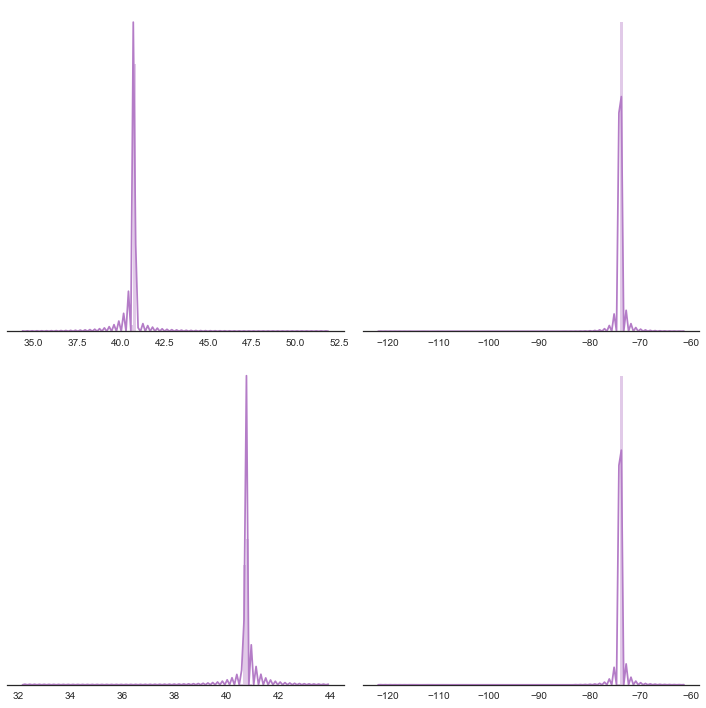

In [5]:
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train_df['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_df['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(train_df['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_df['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

**Note**  
From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 ton-73. We are not getting any histogram kind of plots when we are plotting lat-long as the distplot function of sns is getting affected by outliers, trips which are very far from each other like lat 32 to lat 44, are taking very long time, and have affected this plot such that it is coming off as a spike. Let's remove those large duration trip by using a cap on lat-long and visualize the distributions of latitude and longitude given to us.

Time taken by above cell is 2.9317686557769775.
1452385 1458644


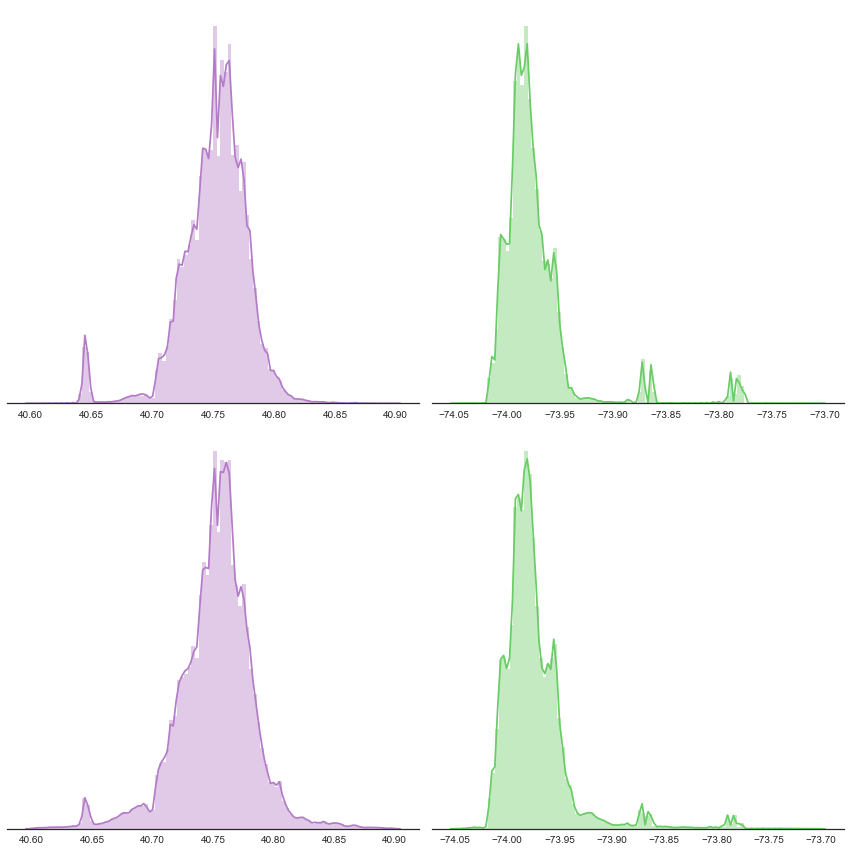

In [6]:
start = time.time()
df = train_df.loc[(train_df.pickup_latitude > 40.6) & (train_df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
train_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
print(df.shape[0], train_data.shape[0])
plt.show()

**Note**  
We put the following caps on lat-long -    

-latitude should be between 40.6 to 40.9  

-longitude should be between -74.05 to -73.70
  
  
We get that the distribution spikes becomes as distribution in distplot (distplot is a histogram plot in seaborn package), we can see that most of the trips are getting concentrated between these lat-long only. Let's plot them on an empty image. 

In [7]:
start = time.time()
temp = train_data.copy()
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_date'] = train_data['pickup_datetime'].dt.date
train_data.head()

ts_v1 = pd.DataFrame(train_data.loc[train_data['vendor_id']==1].groupby('pick_date')['trip_duration'].mean())
ts_v1.reset_index(inplace = True)
ts_v2 = pd.DataFrame(train_data.loc[train_data.vendor_id==2].groupby('pick_date')['trip_duration'].mean())
ts_v2.reset_index(inplace = True)

from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
#from bokeh.sampledata.stocks import AAPL, IBM, MSFT, GOOG
output_notebook()
p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")
p.title.text = 'Click on legend entries to hide the corresponding lines'

for data, name, color in zip([ts_v1, ts_v2], ["vendor 1", "vendor 2"], Spectral4):
    df = data
    p.line(df['pick_date'], df['trip_duration'], line_width=2, color=color, alpha=0.8, legend=name)

p.legend.location = "top_left"
p.legend.click_policy="hide"
show(p)
end = time.time()
train_data = temp
print("Time Taken by above cell is {}.".format(end - start))

Loading BokehJS ...

Time Taken by above cell is 6.998338222503662.


### Heatmap of coordinates 

We have taken an empty image and make it a color it black so that we can see colors where the lat-longs are falling. To visualize we need to consider each point of this image as a point represented by lat-long, to achieve that we will bring the lat-long to image coordinate range and then take a summary of lat-long and their count, assign a different color for different count range.

Time taken by above cell is 8.876229524612427.


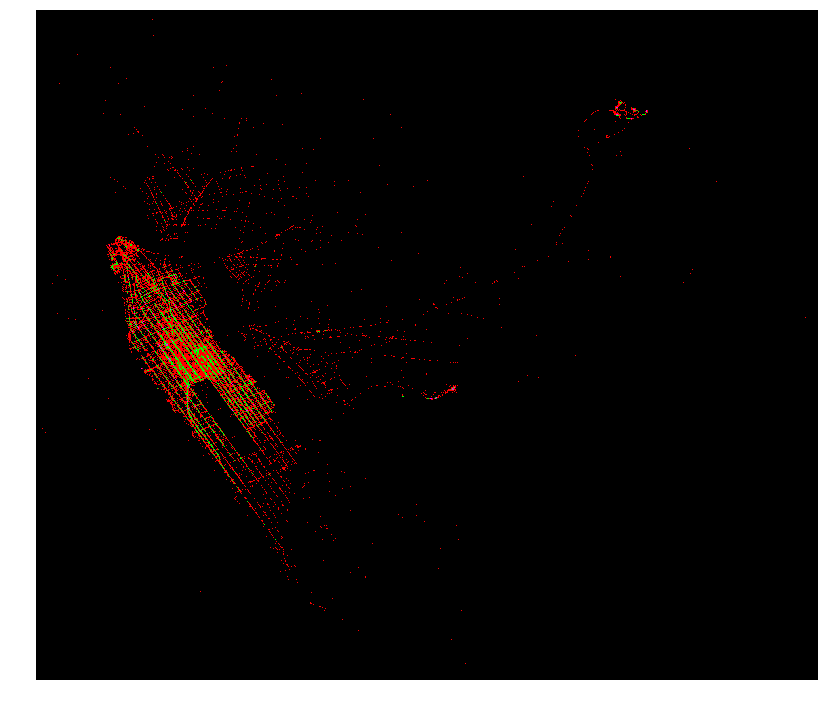

In [8]:
start = time.time()
rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//50) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 255
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

**Note**
From the heatmap kind of image above -

-Red points signifies that 1-10 trips in the given data have that point as pickup point  

-Green points signifies that more than 10-50 trips in the given data have that point as pickup point  

-Yellow points signifies that more than 50+ trips in the given data have that point as pickup point  
  
  
Clearly, the whole manhattan is yellow colored and with few green points as well, that shows that in Manhatten most of the trips are getting originated. This is the basic way in which we can plot large geospatial data in an empty image without being dependent on any package. But if you hate image processing, you can use **datashader**, datashader is a package which is used to show billions of data points on an image, they also use the similar approach with a different color gradient. 

## NYC_taxi_trip_duration Data Understanding 

In [5]:
np.random.seed(1987)
N = 100000 # number of sample rows in plots
t0 = datetime.datetime.now()
train = pd.read_csv('input/nyc_taxi_trip_duration/train.csv')
test = pd.read_csv('input/nyc_taxi_trip_duration/test.csv')
sample_submission = pd.read_csv('input/nyc_taxi_trip_duration/sample_submission.csv')

**Check the data**

In [36]:
print('We have {} training rows and {} test rows.'.format(train.shape[0], test.shape[0]))
print('We have {} training columns and {} test columns.'.format(train.shape[1], test.shape[1]))
train.head(2)

We have 1458644 training rows and 625134 test rows.
We have 11 training columns and 9 test columns.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [6]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops')
print('Train and test sets are distinct.') if len(np.intersect1d(train.id.values, test.id.values))== 0 else print('oops')
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] else print('oops')
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))

Id is unique.
Train and test sets are distinct.
We do not need to worry about missing values.
The store_and_fwd_flag has only two values {'N', 'Y'}.


In [7]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [39]:
# 1 hour = 3600s
train['trip_duration'].max() // 3600

979

We can see that the max trip_duration is ~ 1000 hours. Fortunately the evaluation metric is RMSLE and not RMSE .  
Outliers will cause less trouble. We could logtransform our target label and use RMSE during training

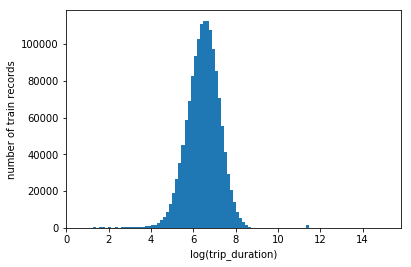

In [16]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

### Validation Strategy

First let's check the train test split.   
It helps to decide our validation strategy and gives ideas about feature engineering.

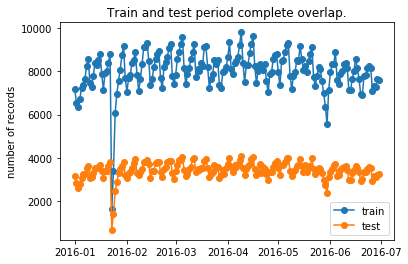

In [17]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

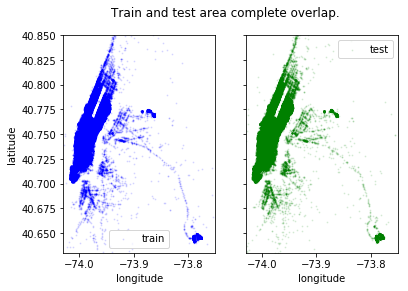

In [18]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In this case the train and test split seems to be random.   
This allows us to use unsupervised learning and feature extraction to be applied on the full data set.

### Feature Extraction

#### PCA (Principal Component Analysis)

We use PCA to transform longitude and latitude coordinates.   
In this case it is not about dimension reduction since we transform 2D-> 2D. The rotation could help for decision tree splits.

In [19]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

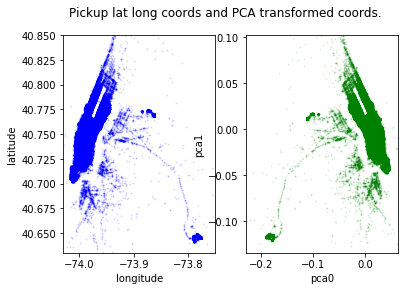

In [20]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

#### Distance

Let's calculate the distance (km) between pickup and dropoff points. Currently Haversine is used, geopy has another heuristics (vincenty() or great_circle()) if you prefer. The cabs are not flying and we are in New York so we could check the Manhattan (L1) distance too.  
  
  

pd.DataFrame.apply() would be too slow so the haversine function is rewritten to handle arrays. We extraxt the middle of the path as a feature as well.

In [21]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

#### Datetime features

In [22]:
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

#### Speed

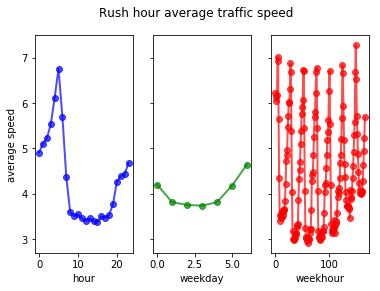

In [23]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

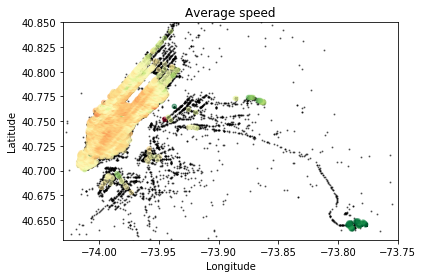

In [24]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N],
           color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

### Clustering

In [25]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [26]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])
t1 = datetime.datetime.now()
print('Time till clustering: %i seconds' % (t1 - t0).seconds)

Time till clustering: 199 seconds


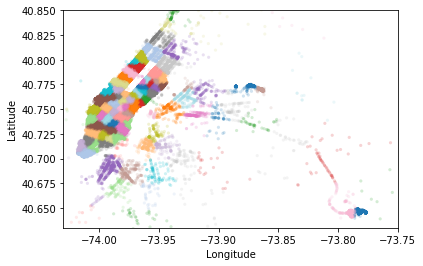

In [27]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

### Temporal and geospatial aggregation

Add a few average traffic speed features.   
Note that if the train/test split would be time based then we could not use as much temporal features. 

In [28]:
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin',
               'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [29]:
group_freq = '60min'
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')

# Count how many trips are going to each cluster over time
dropoff_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

In [30]:
# Count how many trips are going from each cluster over time
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

## Take advantage of OSRM features

We had only rough distance estimates in the previous versions.   
Now we use better fastest route distance estimates between pickup and dropoff.

In [31]:
fr1 = pd.read_csv('input/new_york_city_taxi_with_osrm/fastest_routes_train_part_1.csv',
                  usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('input/new_york_city_taxi_with_osrm/fastest_routes_train_part_2.csv',
                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('input/new_york_city_taxi_with_osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')
train_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [32]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime',
                           'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m',
                           'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin',
                           'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()
y = np.log(train['trip_duration'].values + 1)

t1 = datetime.datetime.now()
print('Feature extraction time: %i seconds' % (t1 - t0).seconds)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
We have 62 features.
Feature extraction time: 312 seconds


### Feature check before modeling

It might save us some headache to check our train and test feature distributions before modeling. Usually in kaggle competitions train and test sets are iid. If there is huge differenc between train and test set than probably we have a bug in our feature extraction pipeline.

In [33]:
feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

,feature,train_test_mean_diff
21,pickup_dt,0.002648
51,cnt_pickup_hour_pickup_cluster,0.002718
7,pickup_pca0,0.002774
10,dropoff_pca1,0.002833
18,pickup_hour_weekofyear,0.002872


In [34]:
feature_stats = feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature', 'train_nan', 'test_nan', 'train_test_nan_diff']].tail()

,feature,train_nan,test_nan,train_test_nan_diff
22,pickup_week_hour,0.000,0.000,0.000
19,pickup_hour,0.000,0.000,0.000
18,pickup_hour_weekofyear,0.000,0.000,0.000
55,cnt_pickup_cluster_dropoff_cluster,0.105,0.107,0.002
54,avg_speed_h_pickup_cluster_dropoff_cluster,0.105,0.107,0.002


Even the top mean difference is less than 1% of the standard deviation. We have a few missing values but the missing rates are the same. Fortunately xgboost can handle missing values.

## Modeling

In [35]:
import xgboost as xgb
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [36]:
# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:4.22515	valid-rmse:4.22634
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.398176	valid-rmse:0.412472
[20]	train-rmse:0.368241	valid-rmse:0.389358
[30]	train-rmse:0.360362	valid-rmse:0.386772
[40]	train-rmse:0.354849	valid-rmse:0.385628
[50]	train-rmse:0.351119	valid-rmse:0.384895


In [37]:
print('Modeling RMSLE %.5f' % model.best_score)
t1 = datetime.datetime.now()
print('Training time: %i seconds' % (t1 - t0).seconds)

Modeling RMSLE 0.38408
Training time: 578 seconds


### Feature importance analysis

Xgboost models has feature importance score which is often used. Please note that it does not necessary means that the feature is really important, higher score means that the feature was used in more tree splits. Features with strong correlation or with high cardinality bias the result.  
  
I tried a simple backward feature elimination round. For each feature a new model was trained without that feature. It helps to understand what are the essential features which we should not remove. Since it would take a few hours to train 56 models I use my offline validation result.
  
    
Note that the OSRM features were added later so they are not included in the following section

In [81]:
rmse_wo_feature = [0.39224, 0.38816, 0.38726, 0.38780, 0.38773, 0.38792, 0.38753, 0.38745, 0.38710, 0.38767, 0.38738, 0.38750, 0.38678, 0.39359, 0.38672, 0.38794, 0.38694, 0.38750, 0.38742, 0.38673, 0.38754, 0.38705, 0.38736, 0.38741, 0.38764, 0.38730, 0.38676, 0.38696, 0.38750, 0.38705, 0.38746, 0.38727, 0.38750, 0.38771, 0.38747, 0.38907, 0.38719, 0.38756, 0.38701, 0.38734, 0.38782, 0.38673, 0.38797, 0.38720, 0.38709, 0.38704, 0.38809, 0.38768, 0.38798, 0.38849, 0.38690, 0.38753, 0.38721, 0.38807, 0.38830, 0.38750, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
feature_importance_dict = model.get_fscore()
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names, 'rmse_wo_feature': rmse_wo_feature})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)

feature_importance[['feature_name', 'importance', 'rmse_wo_feature']].sort_values(by='importance', ascending=False)

,feature_name,importance,rmse_wo_feature
49,total_travel_time_x,1158,0.38710
22,distance_dummy_manhattan,822,0.38794
12,distance_haversine,780,0.38672
52,pickup_pca1,748,0.38750
40,center_longitude,723,0.38673
9,direction,702,0.38694
15,total_distance_x,694,0.38745
3,pickup_dt,599,0.38764
57,pickup_pca0,545,0.38738
16,dropoff_pca1,543,0.39359


The following plot shows the feature elimination result and the xgboost importance. A few observations:  
  
-We had quite a few location related feature with high feature importance score although removing just one of them does not really increase the error.  

-Vendor_id is the second least used feature according to feature importance plot but removing it increases the rmse significantly. It is binary value, even a few decision trees using it captures its information.  

-Direction is important from both aspect. It does not have many correlated feature and removing it would hurt the model.  

-There are lots of different features which could be removed without really breaking a leg.  



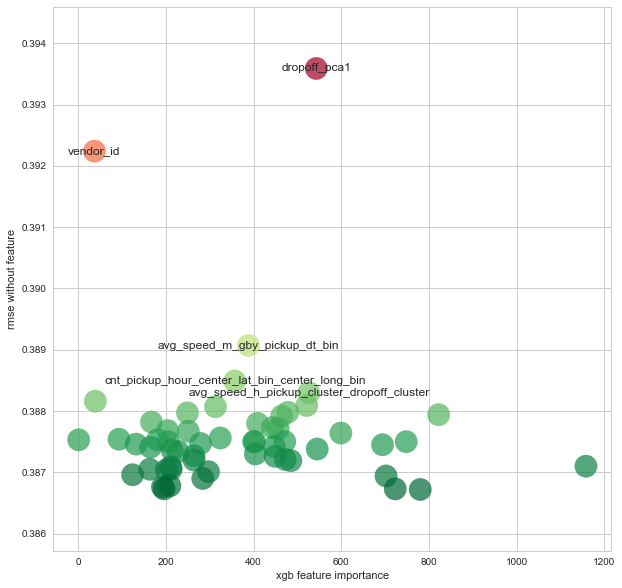

In [82]:
feature_importance = feature_importance.sort_values(by='rmse_wo_feature', ascending=False)
feature_importance = feature_importance[feature_importance['rmse_wo_feature'] > 0]
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(feature_importance['importance'].values, feature_importance['rmse_wo_feature'].values,
               c=feature_importance['rmse_wo_feature'].values, s=500, cmap='RdYlGn_r', alpha=0.7)
    for _, row in feature_importance.head(5).iterrows():
        ax.text(row['importance'], row['rmse_wo_feature'], row['feature_name'],
                verticalalignment='center', horizontalalignment='center')
    ax.set_xlabel('xgb feature importance')
    ax.set_ylabel('rmse without feature')
    ax.set_ylim(np.min(feature_importance['rmse_wo_feature']) - 0.001,
                np.max(feature_importance['rmse_wo_feature']) + 0.001)
    plt.show()

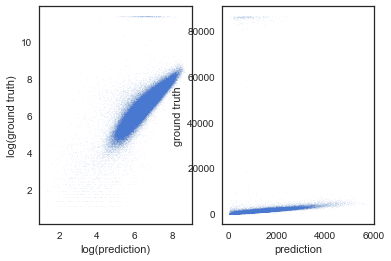

In [83]:
ypred = model.predict(dvalid)
fig,ax = plt.subplots(ncols=2)
ax[0].scatter(ypred, yv, s=0.1, alpha=0.1)
ax[0].set_xlabel('log(prediction)')
ax[0].set_ylabel('log(ground truth)')
ax[1].scatter(np.exp(ypred), np.exp(yv), s=0.1, alpha=0.1)
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('ground truth')
plt.show()

## Submission File for Kaggle Competition

We need to transform back the log duration and save the submission file.  
  
Most of the time the five daily submission slots should me more than enough since you could (and should) validate your experiments locally. If you are working in team or the competition is near to its end then you would like to avoid bugs before submission. Here we check the valid and test prediction distribution. Due to the iid split they should look like the same.  
Checking correlation with previous submissions could give you more confidence.

Test shape OK.
Valid prediction mean: 6.467
Test prediction mean: 6.466


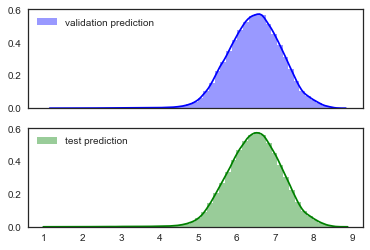

Total time: 3769 seconds


In [88]:
ytest = model.predict(dtest)
print('Test shape OK.') if test.shape[0] == ytest.shape[0] else print('Oops')
test['trip_duration'] = np.exp(ytest) - 1
test[['id', 'trip_duration']].to_csv('submission.csv', index=False, compression='gzip')

print('Valid prediction mean: %.3f' % ypred.mean())
print('Test prediction mean: %.3f' % ytest.mean())

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(ypred, ax=ax[0], color='blue', label='validation prediction')
sns.distplot(ytest, ax=ax[1], color='green', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

t1 = datetime.datetime.now()
print('Total time: %i seconds' % (t1 - t0).seconds)

**The distributions look like identical. We are ready for submission.**

## XGB Parameter Search Result

For parameter tuning, I prefer random search. Usually I try different values for the following parameters

-min_child_weight  
-eta  
-colsample_bytree  
-max_depth  
-subsample  
-lambda

In [2]:
# flag for parameter searching
FOREVER_COMPUTING_FLAG = False
xgb_pars = []
for MCW in [10, 20, 50, 75, 100]:
    for ETA in [0.05, 0.1, 0.15]:
        for CS in [0.3, 0.4, 0.5]:
            for MD in [6, 8, 10, 12, 15]:
                for SS in [0.5, 0.6, 0.7, 0.8, 0.9]:
                    for LAMBDA in [0.5, 1., 1.5,  2., 3.]:
                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 
                                         'colsample_bytree': CS, 'max_depth': MD,
                                         'subsample': SS, 'lambda': LAMBDA, 
                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',
                                         'silent': 1, 'objective': 'reg:linear'})

while FOREVER_COMPUTING_FLAG:
    xgb_par = np.random.choice(xgb_pars, 1)[0]
    print(xgb_par)
    model = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50,
                      maximize=False, verbose_eval=100)
    print('Modeling RMSLE %.5f' % model.best_score)

These experiments would take much time, so a subset of the result is copied here for visualization.

In [6]:
paropt = pd.DataFrame({'lambda':[1.5,1.0,1.0,1.5,1.5,1.0,1.5,1.0,1.5,2.0,0.5,1.0,0.5,1.5,1.5,0.5,1.0,1.5,0.5,2.0,1.0,2.0,2.0,1.5,1.5,2.0,1.5,2.0,1.5,0.5,1.0,1.0,2.0,1.5,1.0,1.0,0.5,2.0,1.0,0.5,0.5,2.0,1.0,1.0,0.5,0.5,1.5,0.5,1.5,2.0,2.0,2.0,2.0,0.5,1.5,1.0,1.5,2.0,2.0,0.5,1.5,1.0,0.5,1.0,1.5,2.0,1.0,1.0,2.0,2.0,1.0,0.5,0.5,1.0,1.5,2.0,0.5,1.0,1.5,1.0,1.0,1.5,1.5,1.5,0.5,1.5,1.0,1.5,2.0,2.0,2.0,1.0,2.0,0.5,2.0,0.5,1.5,0.5,2.0,0.5,1.0,1.5,1.5,1.5,2.0,0.5,0.5,1.0,2.0],
                       'eta':[.1,.1,.05,.05,.05,.15,.15,.1,.1,.05,.15,.15,.15,.1,.1,.1,.1,.05,.15,.05,.05,.05,.15,.15,.05,.05,.05,.05,.15,.15,.15,.15,.1,.05,.05,.1,.1,.1,.1,.1,.05,.15,.15,.15,.1,.1,.05,.05,.15,.15,.15,.1,.1,.05,.05,.05,.05,.05,.15,.1,.1,.15,.1,.1,.05,.15,.15,.15,.1,.05,.05,.05,.05,.15,.1,.1,.1,.1,.05,.05,.05,.15,.15,.1,.1,.1,.1,.05,.15,.15,.1,.1,.1,.05,.05,.1,.1,.1,.1,.1,.05,.15,.15,.15,.15,.05,.05,.15,.15],
                       'min_child_weight': [50,50,20,100,10,50,100,100,75,10,10,50,50,100,75,100,50,10,20,10,75,20,50,75,100,100,10,20,75,75,75,20,10,75,10,100,100,10,20,20,50,50,100,20,50,100,100,75,20,75,20,50,20,10,20,20,20,75,20,75,100,10,10,20,10,20,100,75,75,10,100,50,100,100,50,10,75,75,50,10,75,75,50,75,20,100,100,50,20,20,50,50,75,20,50,100,75,75,100,75,10,10,20,20,10,10,75,50,20],
                       'subsample':[.8,.9,.8,.6,.6,.6,.9,.6,.5,.9,.8,.9,.7,.5,.5,.9,.7,.7,.5,.8,.5,.9,.6,.6,.8,.8,.8,.7,.5,.5,.9,.9,.5,.6,.7,.8,.8,.6,.9,.7,.8,.6,.6,.9,.7,.7,.8,.6,.6,.5,.9,.8,.7,.6,.6,.6,.5,.9,.8,.5,.7,.6,.8,.6,.8,.8,.6,.7,.9,.5,.7,.5,.9,.7,.8,.9,.9,.7,.8,.5,.7,.8,.6,.8,.8,.5,.9,.5,.5,.7,.8,.6,.6,.8,.7,.6,.6,.6,.7,.7,.8,.6,.5,.9,.7,.6,.9,.5,.5],
                       'rmse': [.380,.380,.377,.378,.378,.386,.382,.382,.383,.374,.386,.381,.385,.383,.383,.379,.381,.376,.389,.375,.381,.374,.385,.385,.378,.377,.375,.376,.385,.386,.382,.384,.384,.379,.376,.380,.380,.382,.380,.382,.378,.385,.384,.383,.383,.383,.379,.381,.386,.387,.381,.380,.380,.377,.377,.377,.379,.376,.382,.385,.382,.386,.380,.382,.375,.383,.385,.384,.379,.378,.380,.381,.378,.384,.380,.377,.379,.383,.380,.380,.380,.383,.385,.381,.379,.386,.380,.383,.387,.383,.382,.384,.385,.377,.380,.383,.383,.383,.382,.382,.377,.386,.388,.382,.384,.379,.378,.387,.388]
                       })

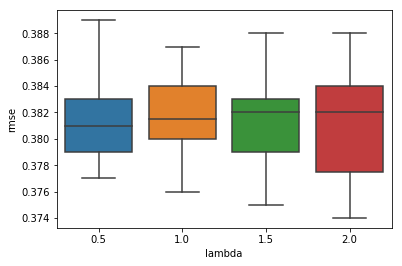

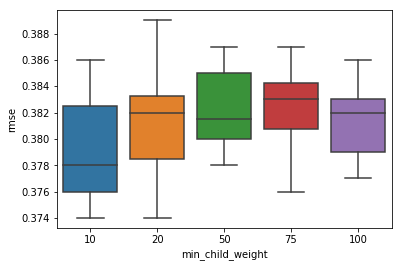

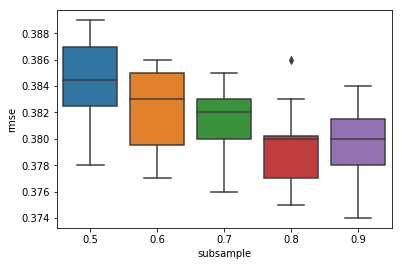

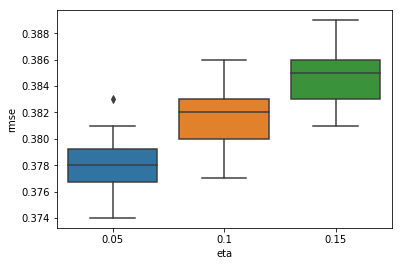

In [12]:
for i, par in enumerate(['lambda', 'min_child_weight', 'subsample', 'eta']):
    fig, ax = plt.subplots()
    ax = sns.boxplot(x=par, y="rmse", data=paropt)
plt.show()    

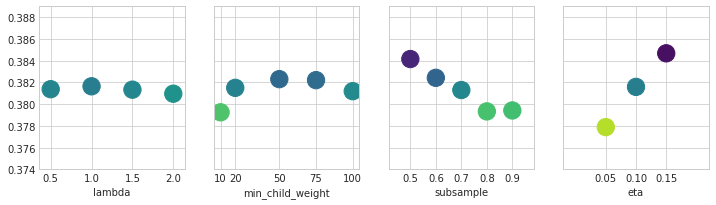

In [11]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(ncols=4, sharey=True, figsize=(12, 3))
    for i, par in enumerate(['lambda', 'min_child_weight', 'subsample', 'eta']):
        mean_rmse = paropt.groupby(par).mean()[['rmse']].reset_index()
        axs[i].scatter(mean_rmse[par].values, mean_rmse['rmse'].values, c=mean_rmse['rmse'].values,
                       s=300, cmap='viridis_r', vmin=.377, vmax=.385, )
        axs[i].set_xlabel(par)
        axs[i].set_xticks(mean_rmse[par].values)
        axs[i].set_ylim(paropt.rmse.min(), paropt.rmse.max())
plt.show()

We can see that lower eta could improve the performance significantly. Higher subsample and smaller child limit leads to better results too. Lambda does not really matter.

## Explore the Spatial and Temporal Behavior of the People 

We are going to explore the spatial and temporal behavior of the people of New York as can be inferred by examining their cab usage.

We will see how the patterns of cab usage change throughout the year, throughout the week and throughout the day, and we will focus on difference between weekdays and weekends.

In [14]:
dataDir = 'input/nyc_taxi_trip_duration/'
taxiDB = pd.read_csv(dataDir + 'train.csv')

# remove obvious outliers
allLat  = np.array(list(taxiDB['pickup_latitude'])  + list(taxiDB['dropoff_latitude']))
allLong = np.array(list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude']))

longLimits = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
latLimits  = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]
durLimits  = [np.percentile(taxiDB['trip_duration'], 0.4), np.percentile(taxiDB['trip_duration'], 99.7)]

taxiDB = taxiDB[(taxiDB['pickup_latitude']   >= latLimits[0] ) & (taxiDB['pickup_latitude']   <= latLimits[1]) ]
taxiDB = taxiDB[(taxiDB['dropoff_latitude']  >= latLimits[0] ) & (taxiDB['dropoff_latitude']  <= latLimits[1]) ]
taxiDB = taxiDB[(taxiDB['pickup_longitude']  >= longLimits[0]) & (taxiDB['pickup_longitude']  <= longLimits[1])]
taxiDB = taxiDB[(taxiDB['dropoff_longitude'] >= longLimits[0]) & (taxiDB['dropoff_longitude'] <= longLimits[1])]
taxiDB = taxiDB[(taxiDB['trip_duration']     >= durLimits[0] ) & (taxiDB['trip_duration']     <= durLimits[1]) ]
taxiDB = taxiDB.reset_index(drop=True)

allLat  = np.array(list(taxiDB['pickup_latitude'])  + list(taxiDB['dropoff_latitude']))
allLong = np.array(list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude']))

# convert fields to sensible units
medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

taxiDB['duration [min]'] = taxiDB['trip_duration']/60.0
taxiDB['src lat [km]']   = latMultiplier  * (taxiDB['pickup_latitude']   - medianLat)
taxiDB['src long [km]']  = longMultiplier * (taxiDB['pickup_longitude']  - medianLong)
taxiDB['dst lat [km]']   = latMultiplier  * (taxiDB['dropoff_latitude']  - medianLat)
taxiDB['dst long [km]']  = longMultiplier * (taxiDB['dropoff_longitude'] - medianLong)

allLat  = np.array(list(taxiDB['src lat [km]'])  + list(taxiDB['dst lat [km]']))
allLong = np.array(list(taxiDB['src long [km]']) + list(taxiDB['dst long [km]']))

### Plot the resulting histograms of trip duration, latitude and longitude

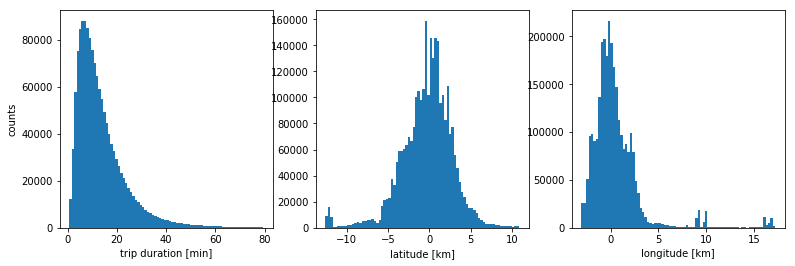

In [17]:
# make sure the ranges we chose are sensible
fig, axArray = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
axArray[0].hist(taxiDB['duration [min]'],80); 
axArray[0].set_xlabel('trip duration [min]'); axArray[0].set_ylabel('counts')
axArray[1].hist(allLat ,80); axArray[1].set_xlabel('latitude [km]')
axArray[2].hist(allLong,80); axArray[2].set_xlabel('longitude [km]')
plt.show()

### Plot the trip Duration vs. the Aerial Distance between pickup and dropoff

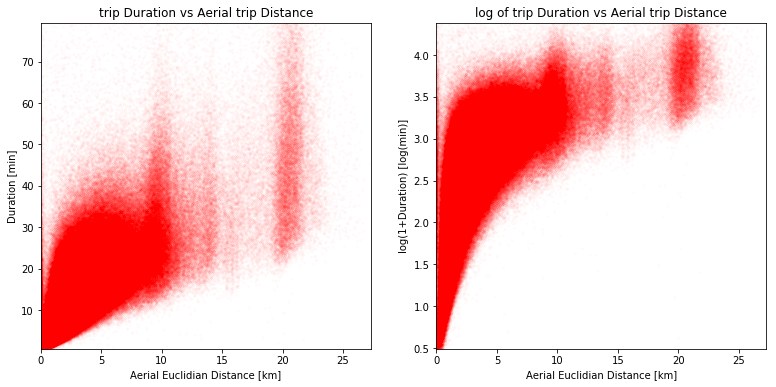

In [18]:
# plot scatter of trip duration vs. aerial distance between pickup and dropoff
taxiDB['log duration']       = np.log1p(taxiDB['duration [min]'])
taxiDB['euclidian distance'] = np.sqrt((taxiDB['src lat [km]']  - taxiDB['dst lat [km]'] )**2 + 
                                       (taxiDB['src long [km]'] - taxiDB['dst long [km]'])**2)

fig, axArray = plt.subplots(nrows=1,ncols=2,figsize=(13,6))
axArray[0].scatter(taxiDB['euclidian distance'], taxiDB['duration [min]'],c='r',s=5,alpha=0.01); 
axArray[0].set_xlabel('Aerial Euclidian Distance [km]'); axArray[0].set_ylabel('Duration [min]')
axArray[0].set_xlim(taxiDB['euclidian distance'].min(),taxiDB['euclidian distance'].max())
axArray[0].set_ylim(taxiDB['duration [min]'].min(),taxiDB['duration [min]'].max())
axArray[0].set_title('trip Duration vs Aerial trip Distance')

axArray[1].scatter(taxiDB['euclidian distance'], taxiDB['log duration'],c='r',s=5,alpha=0.01); 
axArray[1].set_xlabel('Aerial Euclidian Distance [km]'); axArray[1].set_ylabel('log(1+Duration) [log(min)]')
axArray[1].set_xlim(taxiDB['euclidian distance'].min(),taxiDB['euclidian distance'].max())
axArray[1].set_ylim(taxiDB['log duration'].min(),taxiDB['log duration'].max())
axArray[1].set_title('log of trip Duration vs Aerial trip Distance')

plt.show()

We can see that the trip distance defines the lower bound on trip duration, as one would expect.

### Plot spatial density plot of the pickup and dropoff locations

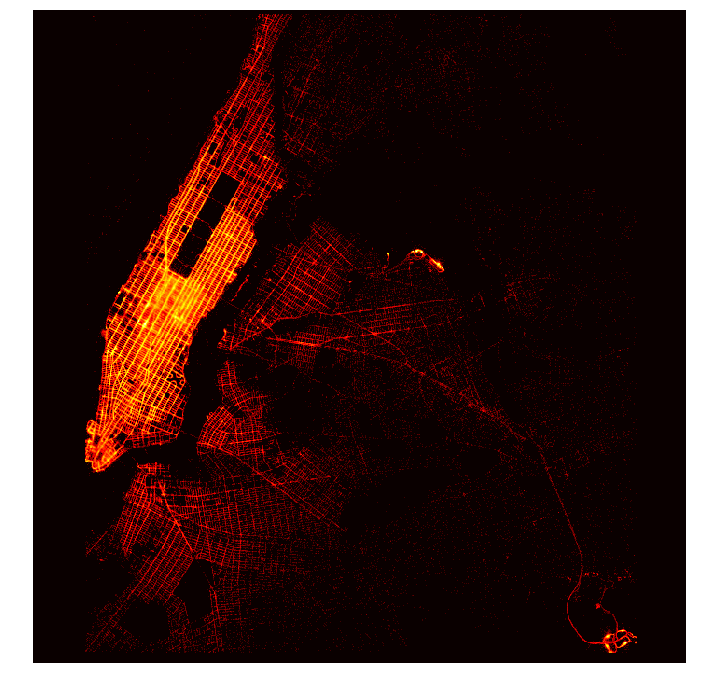

In [21]:
# show the log density of pickup and dropoff locations
imageSize = (700,700)
longRange = [-5,19]
latRange = [-13,11]

allLatInds  = imageSize[0] - (imageSize[0] * (allLat  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
allLongInds =                (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

locationDensityImage = np.zeros(imageSize)
for latInd, longInd in zip(allLatInds,allLongInds):
    locationDensityImage[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.imshow(np.log(locationDensityImage+1),cmap='hot')
ax.set_axis_off()

plt.show()

 Manhattan and the two airports are **lighting**.

### Zoom in on Manhattan

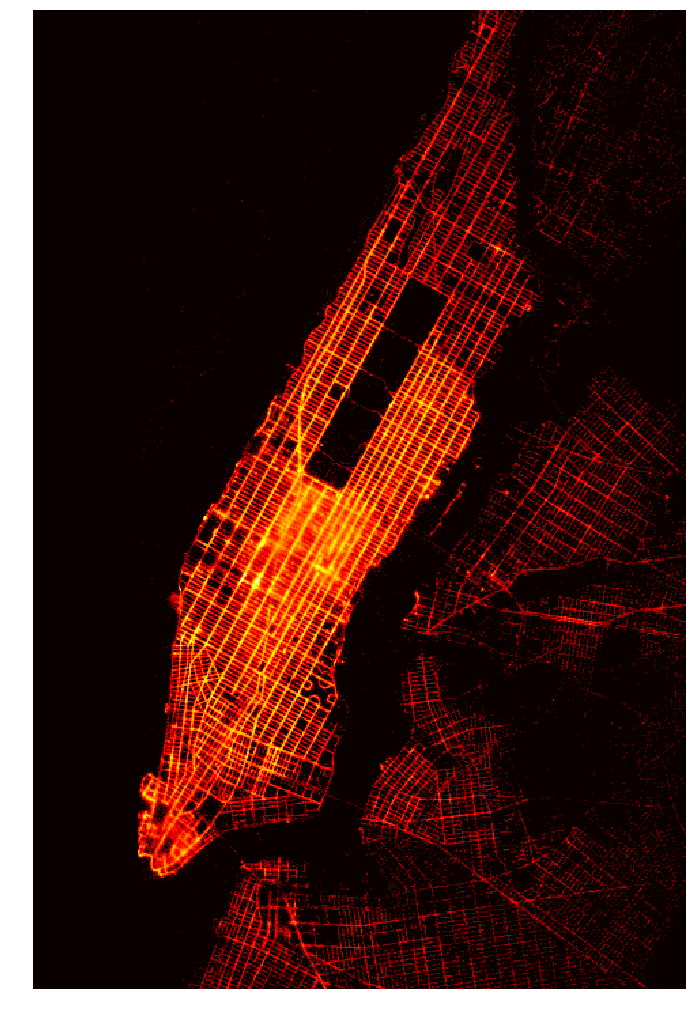

In [22]:
# zoom in on Manhattan 
imageSizeMan = (720,480)
latRangeMan = [-8,10]
longRangeMan = [-5,7]

indToKeep  = np.logical_and(allLat > latRangeMan[0], allLat < latRangeMan[1])
indToKeep  = np.logical_and(indToKeep, np.logical_and(allLong > longRangeMan[0], allLong < longRangeMan[1]))
allLatMan  = allLat[indToKeep]
allLongMan = allLong[indToKeep]

allLatIndsMan  = (imageSizeMan[0]-1) - (imageSizeMan[0] * (allLatMan  - latRangeMan[0])
                                                        / (latRangeMan[1] - latRangeMan[0])).astype(int)
allLongIndsMan =                       (imageSizeMan[1] * (allLongMan - longRangeMan[0])
                                                        / (longRangeMan[1] - longRangeMan[0])).astype(int)

locationDensityImageMan = np.zeros(imageSizeMan)
for latInd, longInd in zip(allLatIndsMan,allLongIndsMan):
    locationDensityImageMan[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,18))
ax.imshow(np.log(locationDensityImageMan+1),cmap='hot')
ax.set_axis_off()

plt.show()

### Create parameters that will be used later

In [23]:
# create some new usefull fields
pickupTime = pd.to_datetime(taxiDB['pickup_datetime'])

taxiDB['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)   / 60.0
taxiDB['dst hourOfDay'] = taxiDB['src hourOfDay'] + taxiDB['duration [min]'] / 60.0

taxiDB['dayOfWeek']     = pickupTime.dt.weekday
taxiDB['hourOfWeek']    = taxiDB['dayOfWeek']*24.0 + taxiDB['src hourOfDay']

taxiDB['monthOfYear']   = pickupTime.dt.month
taxiDB['dayOfYear']     = pickupTime.dt.dayofyear
taxiDB['weekOfYear']    = pickupTime.dt.weekofyear
taxiDB['hourOfYear']    = taxiDB['dayOfYear']*24.0 + taxiDB['src hourOfDay']

### Cluster The Trips and Look at their distribution

Every trip is essentially made up of 5 major attributes: pickup and dropoff locations and the trip duration. let's cluster all 1.4 million trips to 80 stereotypical template trips and then look at the distribution of this "bag of trips" and how it changes over time

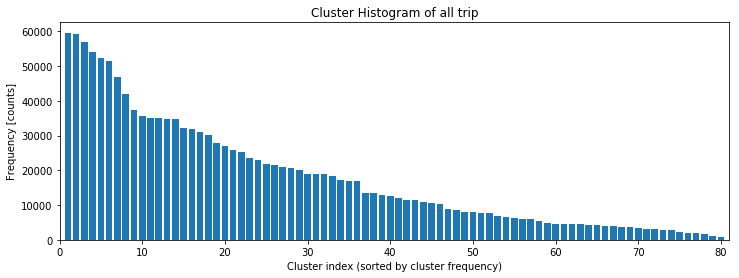

In [26]:
from scipy import stats
from sklearn import cluster
tripAttributes = np.array(taxiDB.loc[:,['src lat [km]','src long [km]','dst lat [km]','dst long [km]','duration [min]']])
meanTripAttr = tripAttributes.mean(axis=0)
stdTripAttr  = tripAttributes.std(axis=0)
tripAttributes = stats.zscore(tripAttributes, axis=0)

numClusters = 80
TripKmeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=120000, n_init=100, random_state=1)
clusterInds = TripKmeansModel.fit_predict(tripAttributes)

clusterTotalCounts, _ = np.histogram(clusterInds, bins=numClusters)
sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

plt.figure(figsize=(12,4)); plt.title('Cluster Histogram of all trip')
plt.bar(range(1,numClusters+1),clusterTotalCounts[sortedClusterInds])
plt.ylabel('Frequency [counts]'); plt.xlabel('Cluster index (sorted by cluster frequency)')
plt.xlim(0,numClusters+1)
plt.show()

### Show the typical Trips on the Map

The magenta circles are sources, the green circles are destinations and the arrows between them are drawn in cyan.

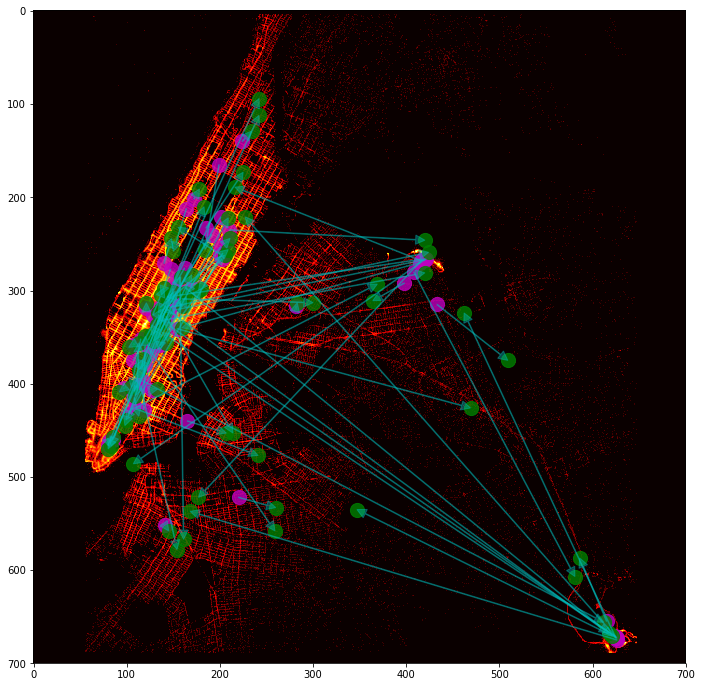

In [29]:
# show the templeate trips on the map
def ConvertToImageCoords(latCoord, longCoord, latRange, longRange, imageSize):
    latInds  = imageSize[0] - (imageSize[0] * (latCoord  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
    longInds =                (imageSize[1] * (longCoord - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

    return latInds, longInds

templateTrips = TripKmeansModel.cluster_centers_ * np.tile(stdTripAttr,(numClusters,1)) + np.tile(meanTripAttr,(numClusters,1))

srcCoords = templateTrips[:,:2]
dstCoords = templateTrips[:,2:4]

srcImCoords = ConvertToImageCoords(srcCoords[:,0],srcCoords[:,1], latRange, longRange, imageSize)
dstImCoords = ConvertToImageCoords(dstCoords[:,0],dstCoords[:,1], latRange, longRange, imageSize)

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='hot'); plt.grid('off')
plt.scatter(srcImCoords[1],srcImCoords[0],c='m',s=200,alpha=0.8)
plt.scatter(dstImCoords[1],dstImCoords[0],c='g',s=200,alpha=0.8)

for i in range(len(srcImCoords[0])):
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='c', facecolor='c', width=0.8,alpha=0.4,head_width=10.0,head_length=10.0,length_includes_head=True)
    
plt.show()

The magenta circles are sources (pickup locations), the green circles are destinations (dropoff locations) and the arrows between them are drawn in cyan. we can see an uneven distribution of sources and destinations with the periphery of Manhattan mostly serve as destination. 

### WeekDay Trip Distribution for different hours of the day

How does this "bag of trips" changes during **the regular work day**?

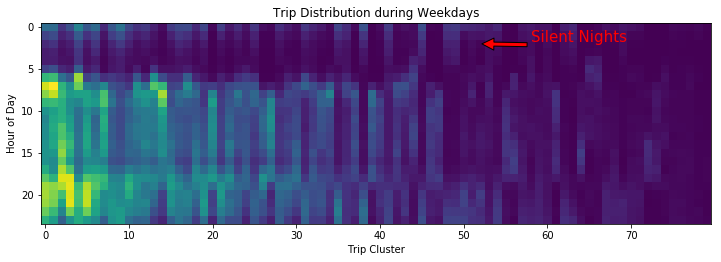

In [30]:
# calculate the trip distribution for different hours of the weekday
hoursOfDay = np.sort(taxiDB['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekday = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (taxiDB['src hourOfDay'].astype(int) == hour) & (taxiDB['dayOfWeek'] <= 4)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekday[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.set_title('Trip Distribution during Weekdays', fontsize=12)
ax.imshow(clusterDistributionHourOfDay_weekday); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')
ax.annotate('Silent Nights', color='r', fontsize=15, xy=(52, 2), xytext=(58, 1.75),
            arrowprops=dict(facecolor='red', shrink=0.03))
plt.show()

Each row contains the "bag of trips" distribution where intensity represents trip frequency.

We can see that around 6AM people start waking up and (most likely) heading off to work. There is a second surge of taxi rides at around 18:00/19:00 (6PM/7PM) which is (most likely) people getting back home. It's also extreemly evindent that during weedays, people are almost not active during the night. This is marked by the red arrow.

### WeekEnd Trip Distribution for different hours of the day

How does this "bag of trips" changes during **the weekend**?

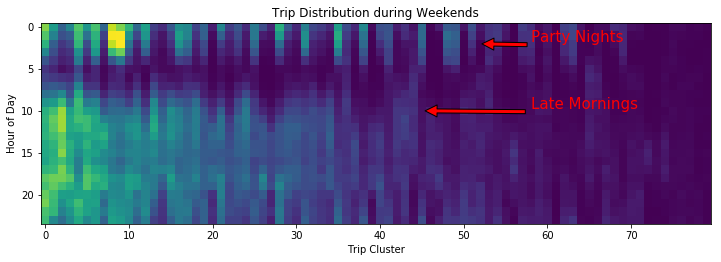

In [31]:
# calculate the trip distribution for different hours of the weekend
hoursOfDay = np.sort(taxiDB['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekend = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (taxiDB['src hourOfDay'].astype(int) == hour) & (taxiDB['dayOfWeek'] >= 5)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekend[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.set_title('Trip Distribution during Weekends', fontsize=12)
ax.imshow(clusterDistributionHourOfDay_weekend); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')
ax.annotate('Party Nights', color='r', fontsize=15, xy=(52, 2), xytext=(58, 1.75),
            arrowprops=dict(facecolor='red', shrink=0.03))
ax.annotate('Late Mornings', color='r', fontsize=15, xy=(45, 10), xytext=(58, 9.75),
            arrowprops=dict(facecolor='red', shrink=0.03))
plt.show()

We can see that during weekends, people are much more active during the night, and also are starting their day much later in the day when compared to regular weekdays. The red arrows mark these two time points on the graph.

### Weekly Trip Distribution for different days of the week

How does this "bag of trips" changes during the **week**?

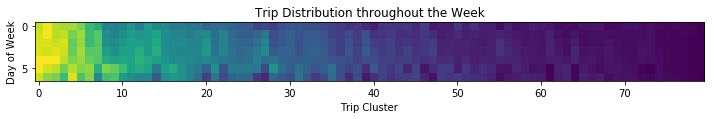

In [32]:
# calculate the trip distribution for day of week
daysOfWeek = np.sort(taxiDB['dayOfWeek'].unique())
clusterDistributionDayOfWeek = np.zeros((len(daysOfWeek),numClusters))
for k, day in enumerate(daysOfWeek):
    slectedInds = taxiDB['dayOfWeek'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionDayOfWeek[k,:] = currDistribution[sortedClusterInds]

plt.figure(figsize=(12,5)); plt.title('Trip Distribution throughout the Week')
plt.imshow(clusterDistributionDayOfWeek); plt.grid('off')
plt.xlabel('Trip Cluster'); plt.ylabel('Day of Week')
plt.show()

We can see a reflection of what we saw from the two previous plots here. that during weekends, the pattern of trip distributions is somewhat different than that during the weekday.

### Yearly Trip Distribution for different days of the year

How does this "bag of trips" changes during the **year**?

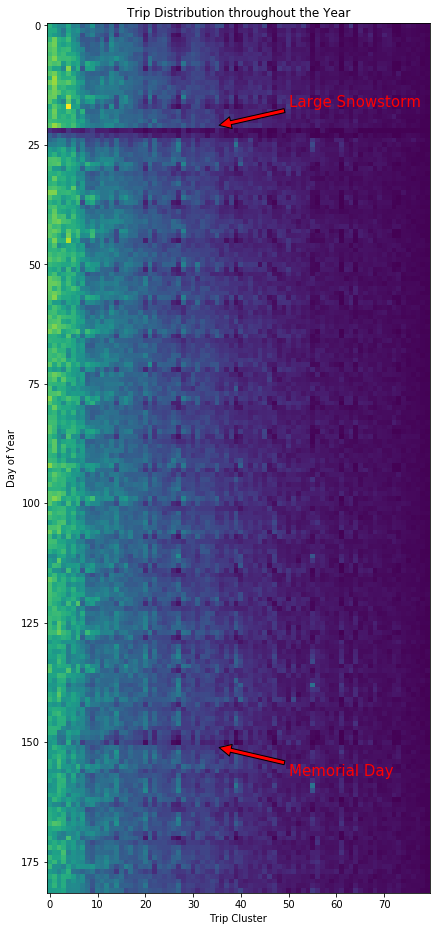

In [33]:
# calculate the trip distribution for day of year
daysOfYear = taxiDB['dayOfYear'].unique()
daysOfYear = np.sort(daysOfYear)
clusterDistributionDayOfYear = np.zeros((len(daysOfYear),numClusters))
for k, day in enumerate(daysOfYear):
    slectedInds = taxiDB['dayOfYear'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionDayOfYear[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,16))
ax.set_title('Trip Distribution throughout the Year', fontsize=12)
ax.imshow(clusterDistributionDayOfYear); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Day of Year')
ax.annotate('Large Snowstorm', color='r', fontsize=15 ,xy=(35, 21), xytext=(50, 17),
            arrowprops=dict(facecolor='red', shrink=0.03))
ax.annotate('Memorial Day', color='r', fontsize=15, xy=(35, 151), xytext=(50, 157),
            arrowprops=dict(facecolor='red', shrink=0.03))
plt.show()

The most obvious pattern here is the periodicity. We can also see two large drops of activity in the data, one around day 20-25 (end of January), and the other around 145-150 (end of May). It turns out that at the end of January there was a large snow storm in NYC, and that in the end of May there is a Memorial Day in the US. These are marked with red arrows.

### delve deeper into The Temporal aspect:

I apply PCA to reduce the dimensionality from the 80 dimensional distribution vector to something more manageable such as 3 dimensions that we can plot and visualize more easily.

In [36]:
# let's apply PCA to reduce the dimentionality from 80 dimentional distribution vector 
# to something more managble such as 3 dimentions
from sklearn import decomposition

hoursOfYear = np.sort(taxiDB['hourOfYear'].astype(int).unique())
clusterDistributionHourOfYear = np.zeros((len(range(hoursOfYear[0],hoursOfYear[-1])),numClusters))
dayOfYearVec  = np.zeros(clusterDistributionHourOfYear.shape[0])
weekdayVec    = np.zeros(clusterDistributionHourOfYear.shape[0])
weekOfYearVec = np.zeros(clusterDistributionHourOfYear.shape[0])
for k, hour in enumerate(hoursOfYear):
    slectedInds = taxiDB['hourOfYear'].astype(int) == hour
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfYear[k,:] = currDistribution[sortedClusterInds]
    
    dayOfYearVec[k]  = taxiDB[slectedInds]['dayOfYear'].mean()
    weekdayVec[k]    = taxiDB[slectedInds]['dayOfWeek'].mean()
    weekOfYearVec[k] = taxiDB[slectedInds]['weekOfYear'].mean()

numComponents = 3
TripDistributionPCAModel = decomposition.PCA(n_components=numComponents,whiten=True, random_state=1)
compactClusterDistributionHourOfYear = TripDistributionPCAModel.fit_transform(clusterDistributionHourOfYear)

### Weekly Periodicity

 Show the temporal evolution of the 3 main principal components coefficients during the week

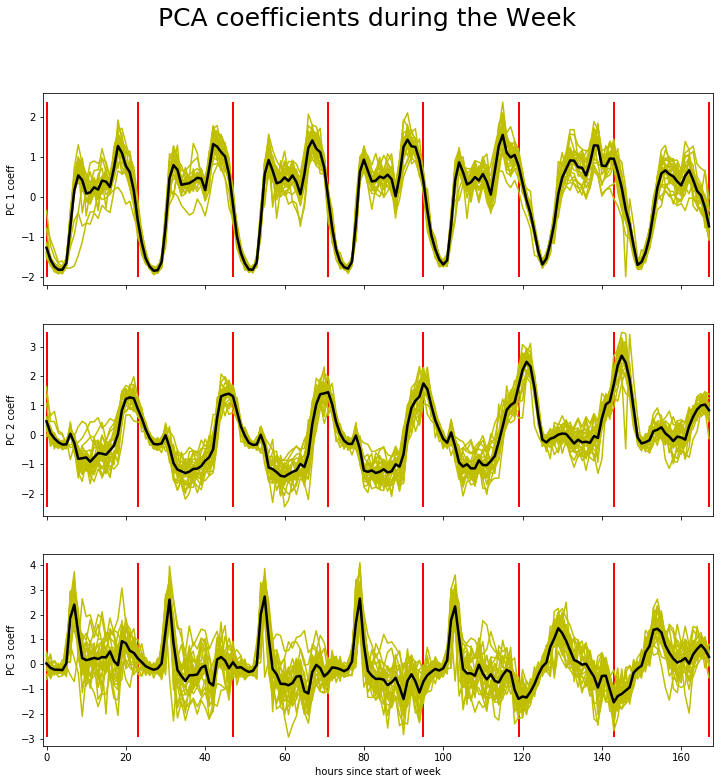

In [37]:
# collect traces for all weeks of year
listOfFullWeeks = []
for uniqueVal in np.unique(weekOfYearVec):
    if (weekOfYearVec == uniqueVal).sum() == 24*7:
        listOfFullWeeks.append(uniqueVal)

weeklyTraces = np.zeros((24*7,numComponents,len(listOfFullWeeks)))
for k, weekInd in enumerate(listOfFullWeeks):
    weeklyTraces[:,:,k] = compactClusterDistributionHourOfYear[weekOfYearVec == weekInd,:]

fig, axArray = plt.subplots(nrows=numComponents,ncols=1,sharex=True, figsize=(12,12))
fig.suptitle('PCA coefficients during the Week', fontsize=25)
for PC_coeff in range(numComponents):
    meanTrace = weeklyTraces[:,PC_coeff,:].mean(axis=1)
    axArray[PC_coeff].plot(weeklyTraces[:,PC_coeff,:],'y',linewidth=1.5)
    axArray[PC_coeff].plot(meanTrace,'k',linewidth=2.5)
    axArray[PC_coeff].set_ylabel('PC %d coeff' %(PC_coeff+1))
    axArray[PC_coeff].vlines([0,23,47,71,95,119,143,167], weeklyTraces[:,PC_coeff,:].min(), weeklyTraces[:,PC_coeff,:].max(), colors='r', lw=2)
    
axArray[PC_coeff].set_xlabel('hours since start of week')
axArray[PC_coeff].set_xlim(-0.9,24*7-0.1)
plt.show()

In yellow is the data from all full weeks overlain on top of each other. In black are the average traces.

We can clearly see the periodicity here as well as the **difference between the regular weekdays and the weekends**.

### Daily Periodicity

Show the temporal evolution of the 3 main principal components coefficients during the day

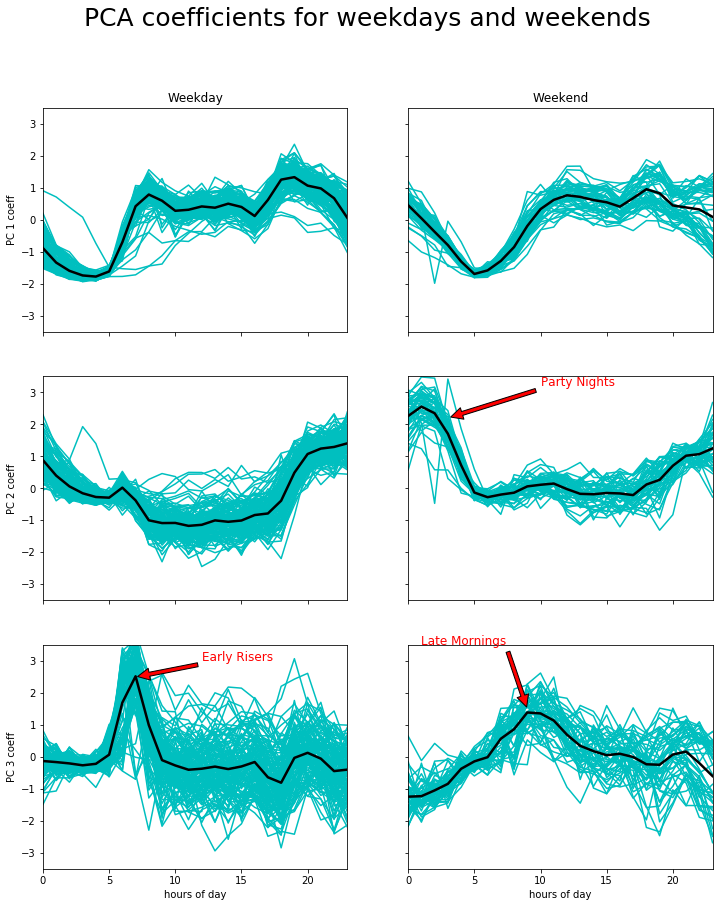

In [38]:
# collect traces for weekdays and weekends 
listOfFullWeekdays = []
listOfFullWeekends = []
for uniqueVal in np.unique(dayOfYearVec):
    if (dayOfYearVec == uniqueVal).sum() == 24:
        if weekdayVec[dayOfYearVec == uniqueVal][0] <= 4:
            listOfFullWeekdays.append(uniqueVal)
        else:
            listOfFullWeekends.append(uniqueVal)

weekdayTraces = np.zeros((24,numComponents,len(listOfFullWeekdays)))
for k, dayInd in enumerate(listOfFullWeekdays):
    weekdayTraces[:,:,k] = compactClusterDistributionHourOfYear[dayOfYearVec == dayInd,:]

weekendTraces = np.zeros((24,numComponents,len(listOfFullWeekends)))
for k, dayInd in enumerate(listOfFullWeekends):
    weekendTraces[:,:,k] = compactClusterDistributionHourOfYear[dayOfYearVec == dayInd,:]

fig, axArray = plt.subplots(nrows=numComponents,ncols=2,sharex=True,sharey=True, figsize=(12,14))
fig.suptitle('PCA coefficients for weekdays and weekends', fontsize=25)
for PC_coeff in range(numComponents):
    axArray[PC_coeff][0].plot(weekdayTraces[:,PC_coeff,:],'c',linewidth=1.5)
    axArray[PC_coeff][0].plot(weekdayTraces[:,PC_coeff,:].mean(axis=1),'k',linewidth=2.5)
    axArray[PC_coeff][0].set_ylabel('PC %d coeff' %(PC_coeff+1))
    
    axArray[PC_coeff][1].plot(weekendTraces[:,PC_coeff,:],'c',linewidth=1.5)
    axArray[PC_coeff][1].plot(weekendTraces[:,PC_coeff,:].mean(axis=1),'k',linewidth=2.5)
    
    if PC_coeff == 0:
        axArray[PC_coeff][0].set_title('Weekday')
        axArray[PC_coeff][1].set_title('Weekend')
    
axArray[PC_coeff][0].set_xlabel('hours of day')
axArray[PC_coeff][1].set_xlabel('hours of day')
axArray[PC_coeff][0].set_xlim(0,23)
axArray[PC_coeff][0].set_ylim(-3.5,3.5)

# add arrows with description
axArray[2][0].annotate('Early Risers', color='r', fontsize=12, xy=(7, 2.5), xytext=(12, 3),
            arrowprops=dict(facecolor='red', shrink=0.03))
axArray[1][1].annotate('Party Nights', color='r', fontsize=12, xy=(3, 2.2), xytext=(10, 3.2),
            arrowprops=dict(facecolor='red', shrink=0.03))
axArray[2][1].annotate('Late Mornings', color='r', fontsize=12, xy=(9, 1.5), xytext=(1, 3.5),
            arrowprops=dict(facecolor='red', shrink=0.03))
plt.show()

Recall that we can go back and see exactly **what each PC**(principal component) **coefficient means** by looking at the eigenvectors (i.e. trip distributions). Let's do that:

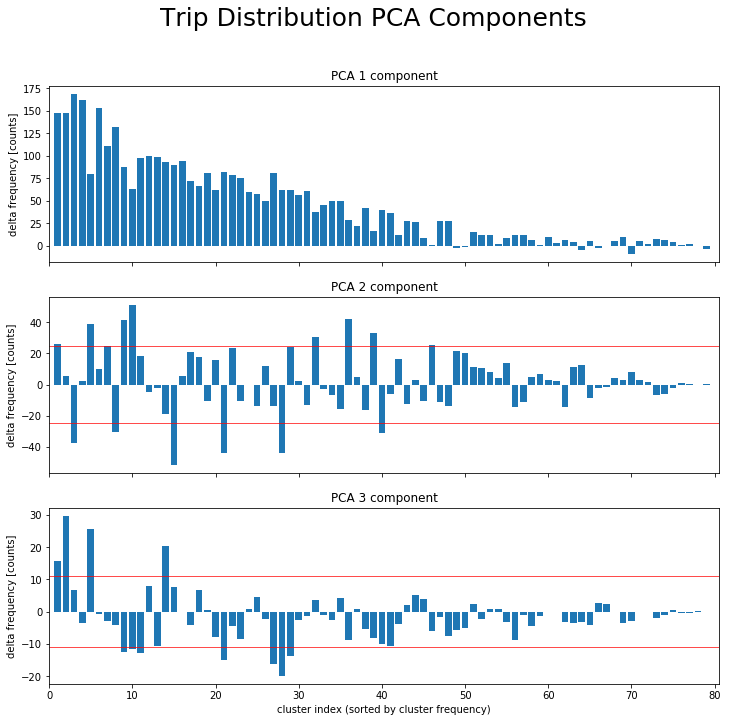

In [39]:
# examine what different PC coefficients mean by looking at their trip template distributions
fig, axArray = plt.subplots(nrows=numComponents,ncols=1,sharex=True, figsize=(12,11))
fig.suptitle('Trip Distribution PCA Components', fontsize=25)
for PC_coeff in range(numComponents):
    tripTemplateDistributionDifference = TripDistributionPCAModel.components_[PC_coeff,:] * \
                                         TripDistributionPCAModel.explained_variance_[PC_coeff]
    axArray[PC_coeff].bar(range(1,numClusters+1),tripTemplateDistributionDifference)
    axArray[PC_coeff].set_title('PCA %d component' %(PC_coeff+1))
    axArray[PC_coeff].set_ylabel('delta frequency [counts]')
    
axArray[PC_coeff].set_xlabel('cluster index (sorted by cluster frequency)')
axArray[PC_coeff].set_xlim(0,numClusters+0.5)

axArray[1].hlines([-25,25], 0, numClusters+0.5, colors='r', lw=0.7)
axArray[2].hlines([-11,11], 0, numClusters+0.5, colors='r', lw=0.7)
plt.show()

We can see that the **first PCA component** looks very similar to the overall trip distribution, suggesting that it's mainly a "gain" component that controls just the **number of total trips** in that period of time.  

The second and third components have different patterns going up and down in them.  

***Let's examine what those patterns are, and in particular everything that deviates from the red lines:***

#### PC 2 large deviating trips

Arrows in red will show trips that are increasing when PC 2 coefficient increases.  

Arrows in blue will show trips that are decreasing when PC 2 coefficient increases.  

Magenta circles are the sources, and Green circles are the destinations.

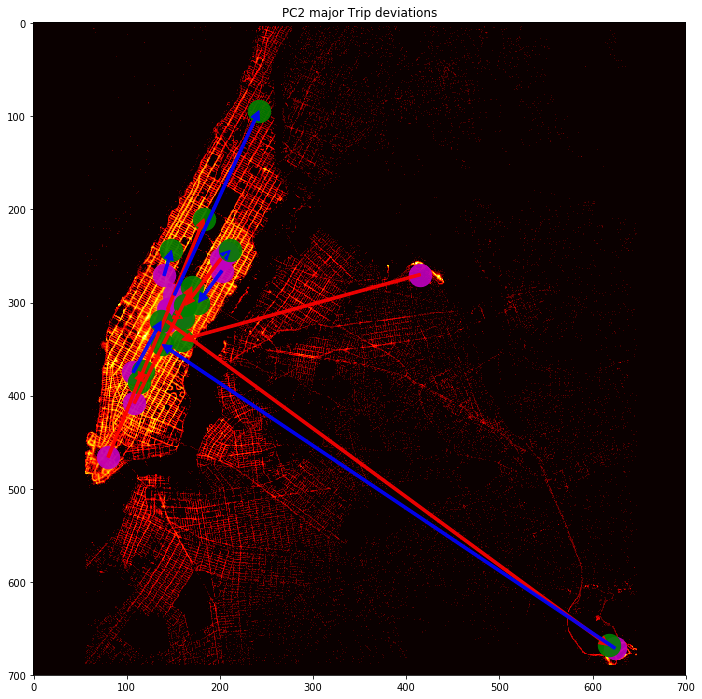

In [43]:
# put the large deviating trips of each component back on the map
numTopTripsToShow = 8
numBottomTripsToShow = 6

# meaning of 2nd PC
sortedTripClusters_PC2 = np.argsort(TripDistributionPCAModel.components_[1,:])
topPositiveTripClusterInds = sortedTripClusters_PC2[-numTopTripsToShow:]
topNegativeTripClusterInds = sortedTripClusters_PC2[:numBottomTripsToShow]
allInds = np.hstack((topPositiveTripClusterInds,topNegativeTripClusterInds))

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='hot'); plt.grid('off')
plt.scatter(srcImCoords[1][allInds],srcImCoords[0][allInds],c='m',s=500,alpha=0.9)
plt.scatter(dstImCoords[1][allInds],dstImCoords[0][allInds],c='g',s=500,alpha=0.9)

for i in topPositiveTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='r', facecolor='r', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)

for i in topNegativeTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='b', facecolor='b', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)
plt.title('PC2 major Trip deviations')
plt.show()

**Arrows in red** show trips that are increasing when PC coefficient increases.  
**Arrows in blue** show trips that are decreasing when PC coefficient increases.  
**Magenta circles** are the sources, and Green circles are the destinations.  
  
We previously saw that **PC2 is about increased activity during the night**. and indeed most of the trips we see are short trips inside manhatten, perhaps people are all going to the hot places.

#### PC 3 large deviating trips

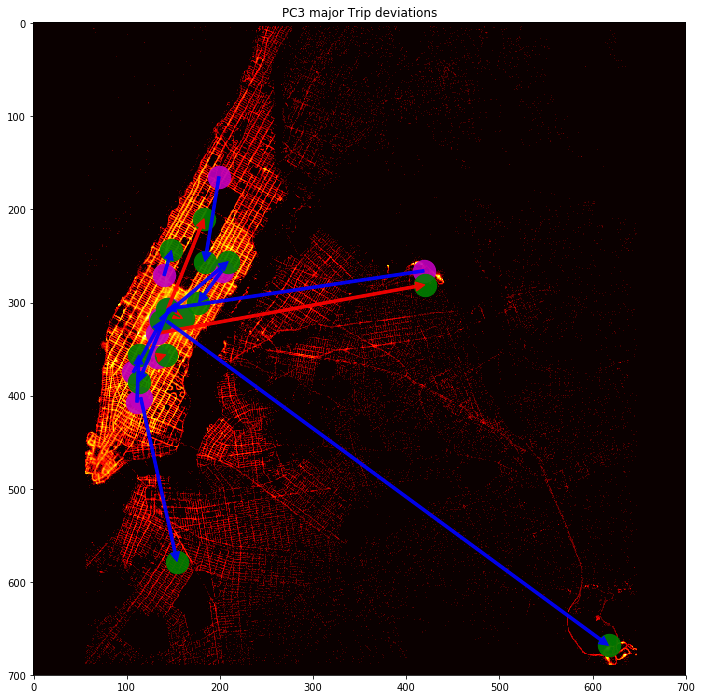

In [44]:
# meaning of 3rd PC
numTopTripsToShow = 4
numBottomTripsToShow = 10

sortedTripClusters_PC3 = np.argsort(TripDistributionPCAModel.components_[2,:])
topPositiveTripClusterInds = sortedTripClusters_PC3[-numTopTripsToShow:]
topNegativeTripClusterInds = sortedTripClusters_PC3[:numBottomTripsToShow]
allInds = np.hstack((topPositiveTripClusterInds,topNegativeTripClusterInds))

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='hot'); plt.grid('off')
plt.scatter(srcImCoords[1][allInds],srcImCoords[0][allInds],c='m',s=500,alpha=0.9)
plt.scatter(dstImCoords[1][allInds],dstImCoords[0][allInds],c='g',s=500,alpha=0.9)

for i in topPositiveTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='r', facecolor='r', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)

for i in topNegativeTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='b', facecolor='b', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)
plt.title('PC3 major Trip deviations')
plt.show()

We previously saw that this is the principal component that indicates what trips are done by the early risers.